# CIFAR 10 PROJECT - object recognition in images

This project have as main porpouse to develop an architecture to realize object recognition in the CIFAR -10 Dataset.

Content

- Preprocesing data
- Architecture ANN
- Transfer learning


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data and preprocesing

In [ ]:
#Import libraries
import sys
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import seaborn as sns
import matplotlib
import itertools
import math
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation, UpSampling2D, Lambda
from tensorflow.keras import  optimizers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from __future__ import print_function

In [ ]:
!pip install colorama
!pip install wandb
!nvidia-smi

from colorama import Cursor, init, Fore
from colorama import Fore, Back, Style

import wandb
from wandb.keras import WandbCallback
wandb.init(project="CIFAR", entity="ejbejaranos")
#API KEY: 2ca93f621998230c8a1a242d9619190c10156f34

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
     |████████████████████████████████| 180 kB 49.9 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 142 kB 53.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=eb4e9315ea8bb32fe5872149279e6c0b1b489d822c39d46ee83c1fca2e457865
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ecb41b7a116ca7d2a8aa1601b38e268e5dc4960b3d1c40b668a161750ea7b276
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
Sun Jan 16 13:03:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Drive

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Function to load the CIFAR datasets from keras
def load_dataset():
  (train_data, train_labels),(test_data, test_labels)  = cifar10.load_data()
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)

  return train_data, train_labels, test_data, test_labels

#Function to normalize the data

def prep_pixels(train_data,test_data):

  train_norm = train_data.astype('float32')
  test_norm = test_data.astype('float32')
  train_normalized = train_norm / 255.0
  test_normalized = test_norm / 255.0

  return train_normalized, test_normalized

Label_Description = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


def show_results(history):
  

  # summarize history for accuracy
  plt.figure(figsize=(20, 8))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Performance accuracy',fontsize=18)
  plt.ylabel( "Accuracy",color="green",fontsize=18)
  plt.xlabel('epoch',fontsize=18)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(20, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Performance loss',fontsize=18)
  plt.ylabel( "Loss",color="red",fontsize=18)
  plt.xlabel('epoch',fontsize=18)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()






def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts


 
def display_images(digits, predictions, labels, title):
  '''utility to display a row of digits with their predictions'''
  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()


In [ ]:
#Load the dataset
train_data, train_labels,test_data, test_labels = load_dataset()
#Normalize dataset
train_normalized, test_normalized = prep_pixels(train_data,test_data)

print(f'{Fore.GREEN+Style.BRIGHT}The training data for the CIFAR dataset has the following dimensionality:{Fore.BLUE+Style.BRIGHT} {train_data.shape}')
print(f'{Fore.GREEN+Style.BRIGHT}The test data for the CIFAR dataset has the following dimensionality:    {Fore.BLUE+Style.BRIGHT} {test_data.shape}')
print(f'{Fore.GREEN+Style.BRIGHT}The labels in the dataset are:{Fore.BLUE+Style.BRIGHT}  {Label_Description}')


170508288/170498071 [==============================] - 11s 0us/step
The training data for the CIFAR dataset has the following dimensionality: (50000, 32, 32, 3)
The test data for the CIFAR dataset has the following dimensionality:     (10000, 32, 32, 3)
The labels in the dataset are:  ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


In [ ]:
#Hyperparametros
data_augmentation = True
num_classes = 10  # Number of class for the dataset
wandb.config = {
  #"learning_rate": 0.001,
  "epochs": 50,
  "batch_size":32, # The default batch size of keras.
  "num_classes": 10 # Number of class for the dataset
}

## Define models and training

### CNN MODEL

In [ ]:
### MODEL1

model1 = Sequential()

model1.add(Conv2D(32, (3, 3), padding='same',input_shape= test_data.shape[1:]))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(32, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())
model1.add(Dropout(0.3))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())
model1.add(Dropout(0.4))

model1.add(Conv2D(128, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())
model1.add(Dropout(0.4))

# FLATTERN => DENSE => RELU => DROPOUT
model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))
# a softmax classifier
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

model1.summary()

# initiate RMSprop optimizer
opt = optimizers.Adam(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

#### Training

In [ ]:
# fit model
history = model1.fit(train_data, train_labels, epochs=50, batch_size=64, validation_data=(test_data, test_labels), verbose=1)

# evaluate model
_, acc = model1.evaluate(test_data, test_labels, verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))

Epoch 1/50
782/782 [==============================] - 42s 52ms/step - loss: 1.6269 - accuracy: 0.4330 - val_loss: 1.3940 - val_accuracy: 0.5138
Epoch 2/50
782/782 [==============================] - 39s 50ms/step - loss: 1.0917 - accuracy: 0.6109 - val_loss: 1.1299 - val_accuracy: 0.6538
Epoch 3/50
782/782 [==============================] - 32s 41ms/step - loss: 0.9112 - accuracy: 0.6791 - val_loss: 0.8071 - val_accuracy: 0.7131
Epoch 4/50
782/782 [==============================] - 34s 44ms/step - loss: 0.8126 - accuracy: 0.7165 - val_loss: 0.7458 - val_accuracy: 0.7383
Epoch 5/50
782/782 [==============================] - 37s 47ms/step - loss: 0.7360 - accuracy: 0.7439 - val_loss: 0.6317 - val_accuracy: 0.7773
Epoch 6/50
782/782 [==============================] - 39s 50ms/step - loss: 0.6880 - accuracy: 0.7618 - val_loss: 0.7561 - val_accuracy: 0.7423
Epoch 7/50
782/782 [==============================] - 35s 44ms/step - loss: 0.6428 - accuracy: 0.7763 - val_loss: 0.5907 - val_accuracy:

In [ ]:
# It can be used to reconstruct the model identically.
model1_reconstructed = keras.models.load_model("/content/drive/My Drive/CI_FINAL_PROJECT/CIFAR10_1.h5")

model1_reconstructed.fit(test_data, test_labels)

313/313 [==============================] - 91s 288ms/step - loss: 0.6532 - accuracy: 0.7987


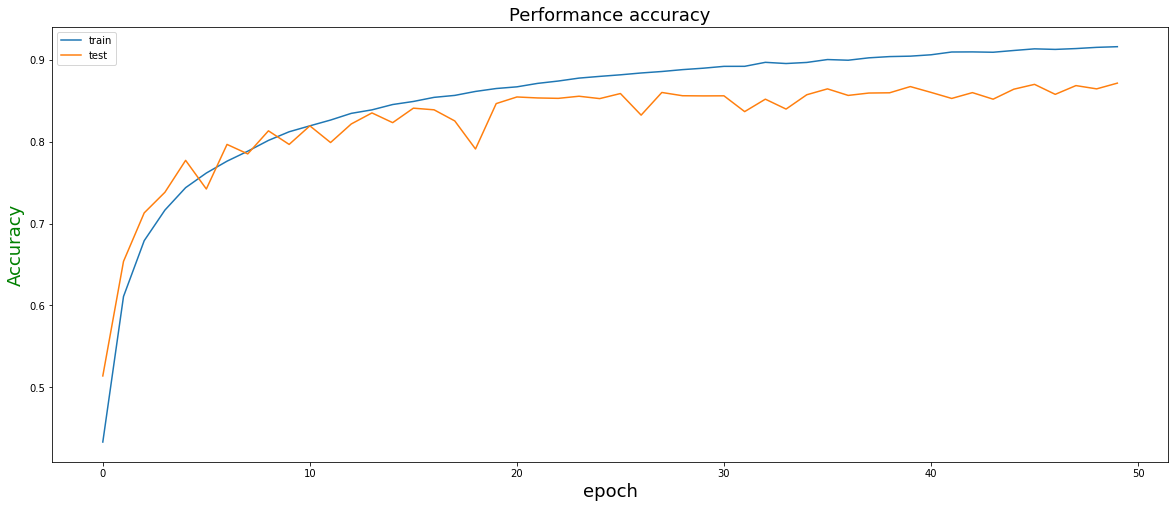

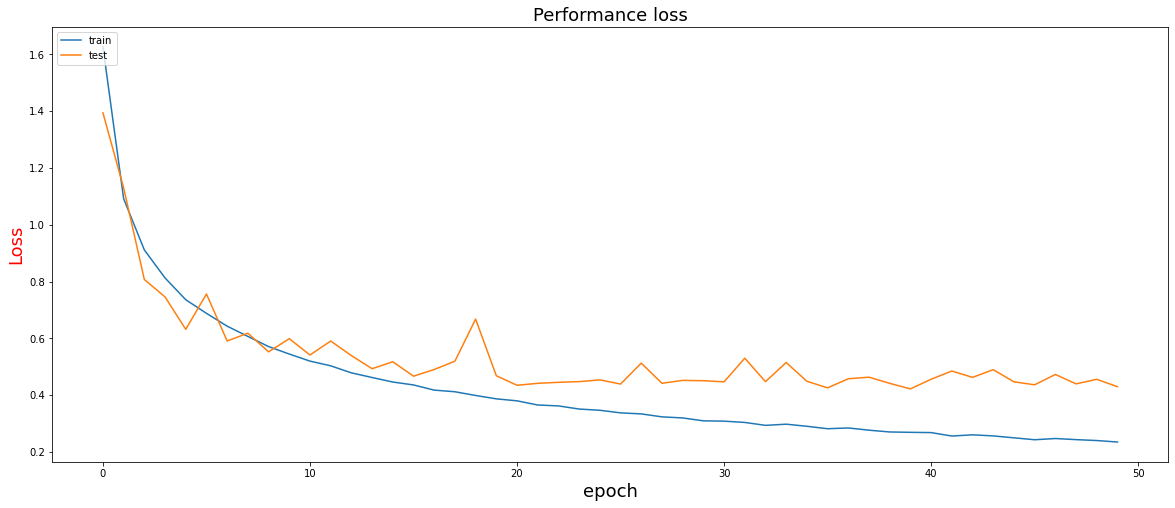

In [ ]:
# list all data in history
print(history.history.keys())
show_results(history)  

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


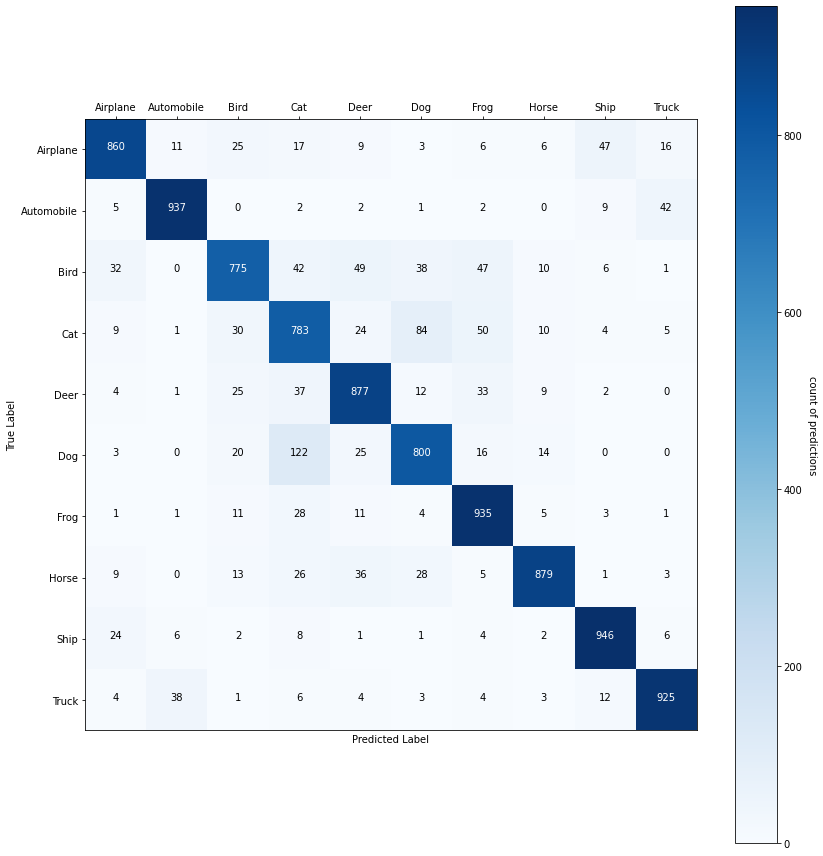

In [ ]:
print(history.history.keys())


# make prediction.
pred = model1.predict(test_data)



# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = test_data[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.



fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, Label_Description, Label_Description, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [ ]:
print(f'{Fore.BLUE+Style.BRIGHT}{Label_Description}')
print(f'{Fore.GREEN+Style.BRIGHT} {classification_report(Y_true, Y_pred_classes)}')

['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      1000
           1       0.94      0.94      0.94      1000
           2       0.86      0.78      0.81      1000
           3       0.73      0.78      0.76      1000
           4       0.84      0.88      0.86      1000
           5       0.82      0.80      0.81      1000
           6       0.85      0.94      0.89      1000
           7       0.94      0.88      0.91      1000
           8       0.92      0.95      0.93      1000
           9       0.93      0.93      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



#### Save the model

In [ ]:
save_dir = os.path.join(os.getcwd(), '/content/drive/My Drive/CI_FINAL_PROJECT')
model_name = 'CIFAR10_1.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model1.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model1.evaluate(test_data, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# Save in wandb
model1.save(os.path.join(wandb.run.dir, "model.h5"))

Saved trained model at /content/drive/My Drive/CI_FINAL_PROJECT/CIFAR10_1.h5 
313/313 [==============================] - 7s 22ms/step - loss: 0.4298 - accuracy: 0.8717
Test loss: 0.4297974705696106
Test accuracy: 0.8716999888420105


In [ ]:
pd.DataFrame(history.history).to_csv('training_log1.csv', index=True)

In [ ]:
# Fit the models
history2 = model1.fit(train_data, train_labels, callbacks=[WandbCallback()], validation_data=(test_data, test_labels), verbose=1)
_, acc2 = model1.evaluate(test_data, test_labels, verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))

313/313 [==============================] - 4s 14ms/step - loss: 0.4562 - accuracy: 0.8566
Accuracy: 87.170


### MODEL2: Transfer Learning Resnet 50 model

In [ ]:

(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)


'''RESNET-50: The original imput size is 224 * 224 '''

def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

'''We create a function to add the final layers and subsequent softmax layer for classification''' 

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


def define_compile_model():
  '''RESNET-50: the size is adapted for the dataset'''
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model_resnet50 = define_compile_model()

model_resnet50.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

#### Training Resnet

In [ ]:
EPOCHS = 5
history_resnet = model_resnet50.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/5
782/782 [==============================] - 525s 671ms/step - loss: 0.0345 - accuracy: 0.9902 - val_loss: 0.1598 - val_accuracy: 0.9495
Epoch 2/5
782/782 [==============================] - 517s 661ms/step - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.1902 - val_accuracy: 0.9437
Epoch 3/5
782/782 [==============================] - 518s 663ms/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.1753 - val_accuracy: 0.9524
Epoch 4/5
782/782 [==============================] - 532s 681ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.1780 - val_accuracy: 0.9541
Epoch 5/5
782/782 [==============================] - 519s 664ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.1749 - val_accuracy: 0.9573


In [ ]:
# list all data in history
history = history_resnet
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


313/313 [==============================] - 29s 94ms/step - loss: 0.1749 - accuracy: 0.9573
Accuracy: 95.730


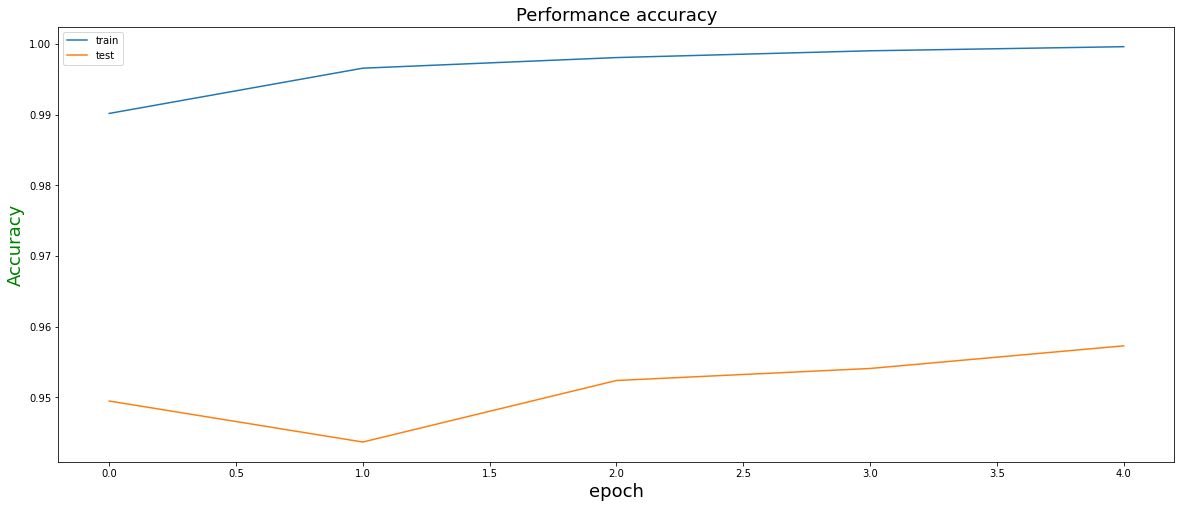

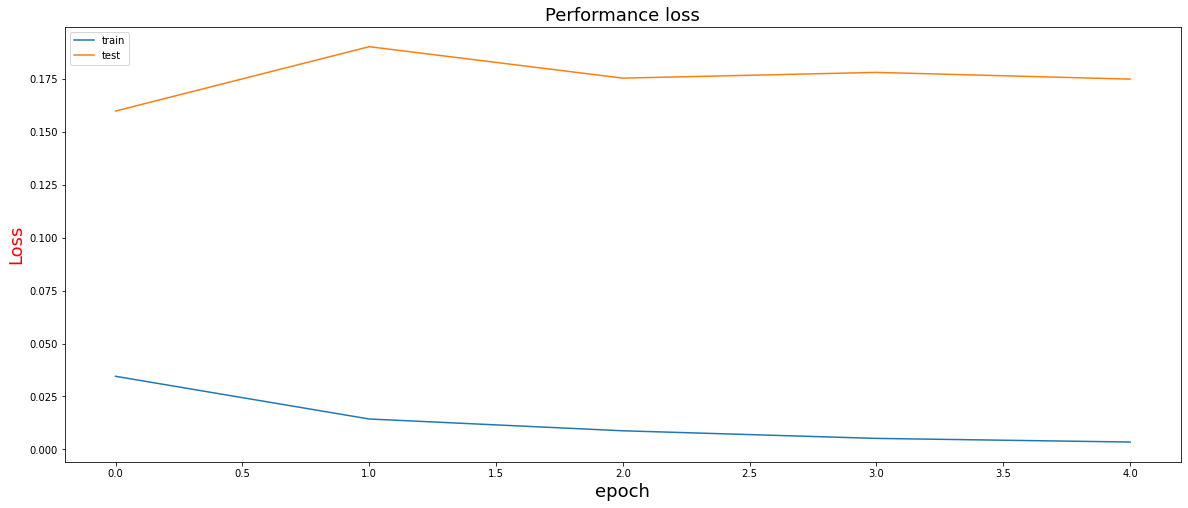

In [ ]:
# evaluate model
_, acc_resnet = model_resnet50.evaluate(valid_X, validation_labels, verbose=1)
print('Accuracy: %.3f' % (acc_resnet * 100.0))
show_results(history_resnet)  

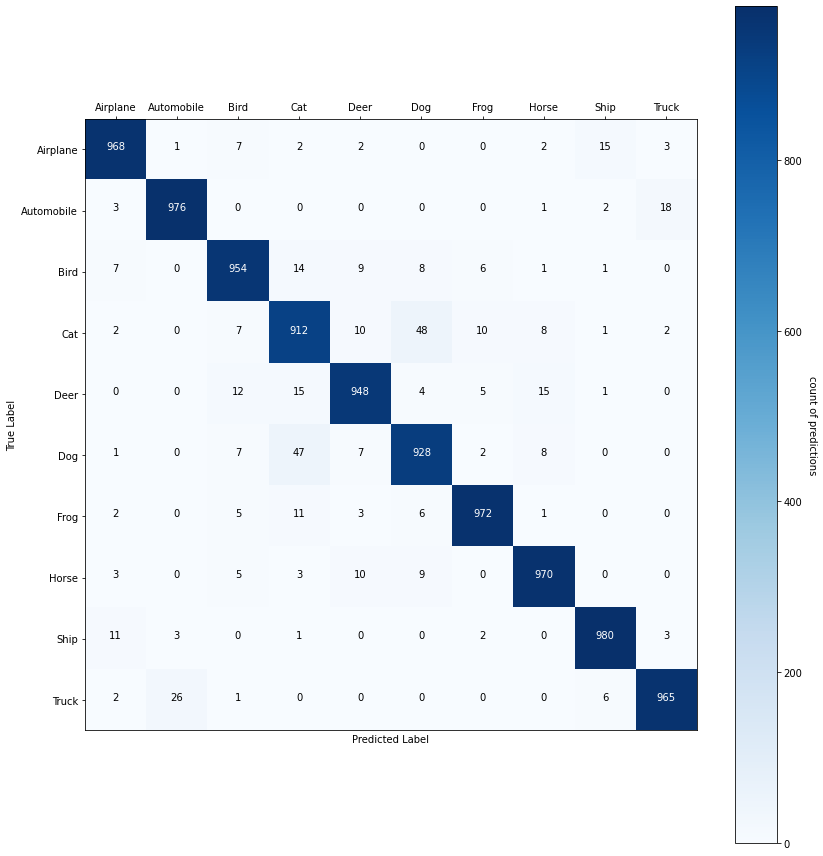

['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.97      0.98      0.97      1000
           2       0.96      0.95      0.95      1000
           3       0.91      0.91      0.91      1000
           4       0.96      0.95      0.95      1000
           5       0.93      0.93      0.93      1000
           6       0.97      0.97      0.97      1000
           7       0.96      0.97      0.97      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [ ]:
# make prediction.
pred_resnet50 = model_resnet50.predict(valid_X)


# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_resnet50, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred_resnet50[errors]
Y_true_errors = Y_true[errors]
X_test_errors = valid_X[errors]

cm_resnet50 = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm_resnet50.max() / 2.



fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm_resnet50, Label_Description, Label_Description, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm_resnet50, threshold=thresh)

fig.tight_layout()
plt.show()

print(f'{Fore.BLUE+Style.BRIGHT}{Label_Description}')
print(f'{Fore.GREEN+Style.BRIGHT} {classification_report(Y_true, Y_pred_classes)}')

#### Save the model

In [ ]:
save_dir = os.path.join(os.getcwd(), '/content/drive/My Drive/CI_FINAL_PROJECT')
model_name = 'CIFAR10_1_Resnet50.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_resnet50.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model_resnet50.evaluate(valid_X, validation_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# Save in wandb
model_resnet50.save(os.path.join(wandb.run.dir, "model_resnet.h5"))


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved trained model at /content/drive/My Drive/CI_FINAL_PROJECT/CIFAR10_1_Resnet50.h5 
313/313 [==============================] - 29s 94ms/step - loss: 0.1749 - accuracy: 0.9573
Test loss: 0.1748552769422531
Test accuracy: 0.9573000073432922


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
import pandas as pd
pd.DataFrame(history.history).to_csv('model_resnet50.csv', index=True)

In [ ]:
# It can be used to reconstruct the model identically.
model1_reconstructed_resnet = keras.models.load_model("/content/drive/My Drive/CI_FINAL_PROJECT/CIFAR10_1_Resnet50.h5")

model1_reconstructed_resnet.fit(valid_X, validation_labels)

313/313 [==============================] - 106s 328ms/step - loss: 0.2831 - accuracy: 0.9154


###  MODEL3: Transfer Learning VGG16


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
def feature_extractor_VGG(inputs):

  feature_extractor = VGG16(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

def classifier_vgg(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.Dense(1024, activation="relu")(x)
    #x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model_VGG(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    vgg_feature_extractor = feature_extractor_VGG(resize)
    classification_output = classifier_vgg(vgg_feature_extractor)

    return classification_output


def define_compile_modelVGG():
  '''VGG-16: the size is adapted for the dataset'''
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model_VGG(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  
  opt = optimizers.Adam(learning_rate=1e-4)
  model.compile(optimizer=opt, 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

model_vgg16 = define_compile_modelVGG()

model_vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                            

In [ ]:
EPOCHS = 15
history_vgg16 = model_vgg16.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/15
782/782 [==============================] - 1373s 2s/step - loss: 0.7961 - accuracy: 0.7268 - val_loss: 0.6267 - val_accuracy: 0.7915
Epoch 2/15
782/782 [==============================] - 1329s 2s/step - loss: 0.3632 - accuracy: 0.8785 - val_loss: 0.4778 - val_accuracy: 0.8417
Epoch 3/15
782/782 [==============================] - 1328s 2s/step - loss: 0.2279 - accuracy: 0.9236 - val_loss: 0.5448 - val_accuracy: 0.8235
Epoch 4/15
782/782 [==============================] - 1328s 2s/step - loss: 0.1481 - accuracy: 0.9508 - val_loss: 0.5682 - val_accuracy: 0.8342
Epoch 5/15
782/782 [==============================] - 1327s 2s/step - loss: 0.0956 - accuracy: 0.9695 - val_loss: 0.3184 - val_accuracy: 0.9003
Epoch 6/15
782/782 [==============================] - 1327s 2s/step - loss: 0.0671 - accuracy: 0.9790 - val_loss: 0.5908 - val_accuracy: 0.8404
Epoch 7/15
782/782 [==============================] - 1325s 2s/step - loss: 0.0579 - accuracy: 0.9817 - val_loss: 0.3596 - val_accuracy:

In [ ]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model3.fit(x_train, y_train,
              batch_size=32,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model_vgg16.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=32),# batch_size
                                    epochs=5, #epochs
                                    validation_data=(x_test,y_test),#(x_test, y_test)
                                    workers=4)

#### Training VGG 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


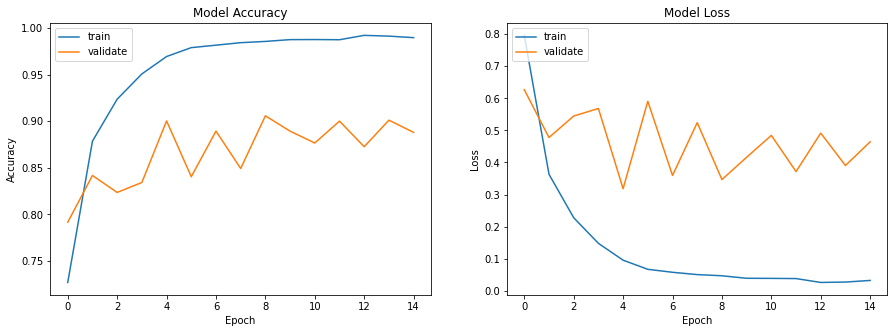

In [ ]:
# list all data in history
history = history_vgg16
print(history.history.keys())

plotmodelhistory(history_vgg16)

In [ ]:
# evaluate model
_, acc_vgg = model_vgg16.evaluate(train_X, training_labels, verbose=1) 

Accuracy: 97.772


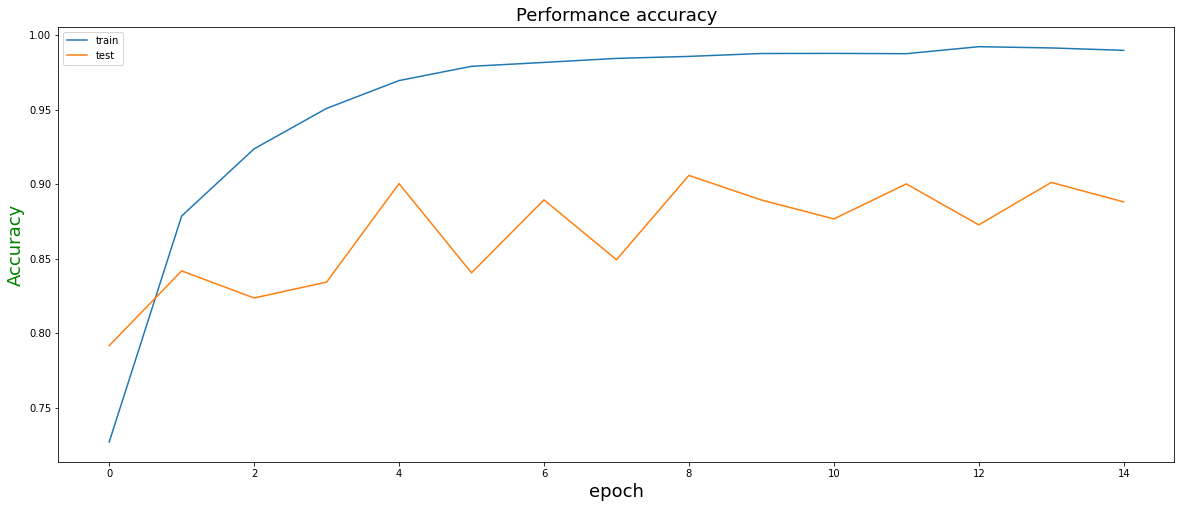

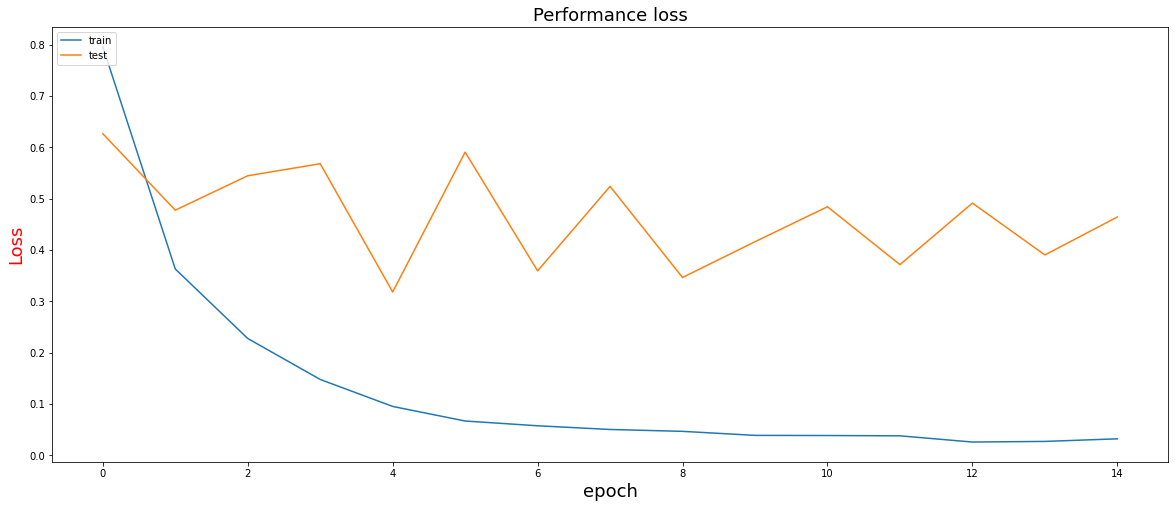

In [ ]:
print('Accuracy: %.3f' % (acc_vgg * 100.0))
show_results(history_vgg16) 

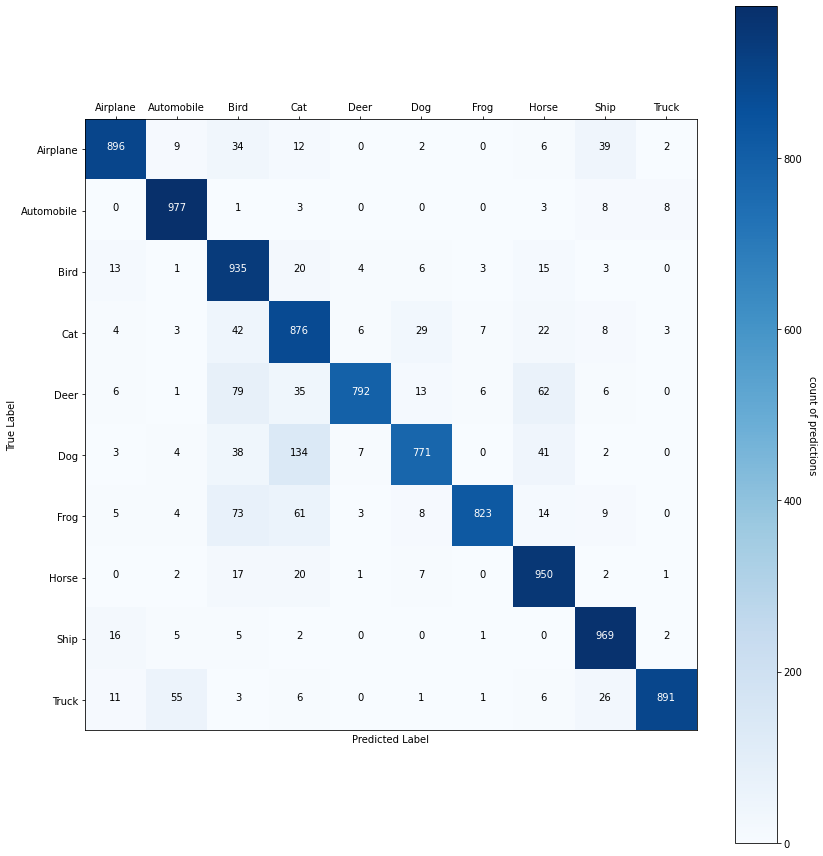

['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      1000
           1       0.92      0.98      0.95      1000
           2       0.76      0.94      0.84      1000
           3       0.75      0.88      0.81      1000
           4       0.97      0.79      0.87      1000
           5       0.92      0.77      0.84      1000
           6       0.98      0.82      0.89      1000
           7       0.85      0.95      0.90      1000
           8       0.90      0.97      0.94      1000
           9       0.98      0.89      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [ ]:
# make prediction.
pred_vgg = model_vgg16.predict(valid_X)


# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_vgg, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred_vgg[errors]
Y_true_errors = Y_true[errors]
X_test_errors = test_data[errors]

cm_vgg = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm_vgg.max() / 2.



fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm_vgg, Label_Description, Label_Description, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm_vgg, threshold=thresh)

fig.tight_layout()
plt.show()

print(f'{Fore.BLUE+Style.BRIGHT}{Label_Description}')
print(f'{Fore.GREEN+Style.BRIGHT} {classification_report(Y_true, Y_pred_classes)}')

#### Save the model

In [ ]:
save_dir = os.path.join(os.getcwd(), '/content/drive/My Drive/')
model_name = 'CIFAR10_vgg16.h5'
history =history_vgg16


# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_vgg16.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model_vgg16.evaluate(valid_X, validation_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# Save in wandb
model_vgg16.save(os.path.join(wandb.run.dir, "model_vgg.h5"))
pd.DataFrame(history.history).to_csv('training_vgg.csv', index=False)

Saved trained model at /content/drive/My Drive/CIFAR10_vgg16.h5 
313/313 [==============================] - 73s 235ms/step - loss: 0.4645 - accuracy: 0.8880
Test loss: 0.4644690454006195
Test accuracy: 0.8880000114440918
